Purpose: Develop code for the random forest for peripheral stress response: a binary classifier where class 0 = a single stress and class 1 = all other stressors (no control data).<br>
Author: Anna Pardo<br>
Date initiated: August 16, 2023

In [104]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import random
from itertools import takewhile

In [2]:
# main code that needs to be worked out: data loading & cleaning function
def load_clean_data(path_to_tpm,single_stress):
    """
    Args:
        path_to_tpm = full path to file containing raw TPM, columns for Sample, BioProject, & Treatment
        single_stress = the stressor that will be class 0
    """
    # load the TPM data
    raw_tpm = pd.read_csv(path_to_tpm,sep="\t",header="infer")
    # replace DroughtRepeat with Drought
    raw_tpm["Treatment"].mask(raw_tpm["Treatment"]=="DroughtRepeat","Drought",inplace=True)
    # drop control samples
    raw_tpm = raw_tpm[raw_tpm["Treatment"]!="Control"]
    # labeling: set single_stress to 0 and any stress to 1
    proxy = []
    for i in range(len(raw_tpm.index)):
        if raw_tpm.iloc[i,raw_tpm.columns.get_loc("Treatment")] == single_stress:
            proxy.append(0)
        else:
            proxy.append(1)
    raw_tpm["Label"] = proxy
    # return the dataframe
    return raw_tpm

In [3]:
tpm = load_clean_data("../../data/rawtpm_bptreat_noPEG.tsv",single_stress="Heat")

In [8]:
tpm.head()

,Sample,BioProject,Treatment,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030,Label
0,SRR11933261,PRJNA637522,Drought,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,...,0.000000,0.0,0.000000,0.0,0.309501,0.0,0.000000,0.0,0.000000,1
1,SRR11933272,PRJNA637522,Drought,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,...,0.127878,0.0,0.000000,0.0,6.703281,0.0,0.000000,0.0,0.000000,1
2,SRR11933250,PRJNA637522,Drought,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,...,0.000000,0.0,0.000000,0.0,0.417565,0.0,0.254123,0.0,1.213349,1
4,SRR11933040,PRJNA637522,Drought,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,...,0.012158,0.0,0.000000,0.0,9.625225,0.0,0.000000,0.0,2.352959,1
5,SRR11932822,PRJNA637522,Drought,37.430009,27.508819,0.000000,29.510498,7.005587,0.367545,0.314919,...,0.000000,0.0,0.287114,0.0,0.000000,0.0,0.000000,0.0,1.604105,1


In [9]:
# for each stressor: plot the number of samples in each BioProject, with labels
## write a function to do so
def nsamp_bioprojects(stressor,tpmdf):
    # subset to the specified stressor
    df = tpmdf[tpmdf["Treatment"]==stressor]
    bp = df["BioProject"].unique()
    nsamp = []
    for b in bp:
        d = df[df["BioProject"]==b]
        nsamp.append(len(d["Sample"].unique()))
    plotdf = pd.DataFrame(list(zip(bp,nsamp)),columns=["BioProject","N_samples"])
    # plot horizontal barplot
    plt.barh(plotdf["BioProject"],plotdf["N_samples"])
    plt.title(stressor)

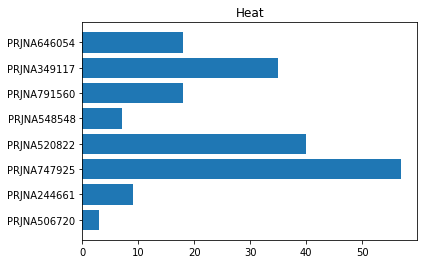

In [12]:
nsamp_bioprojects("Heat",tpm)

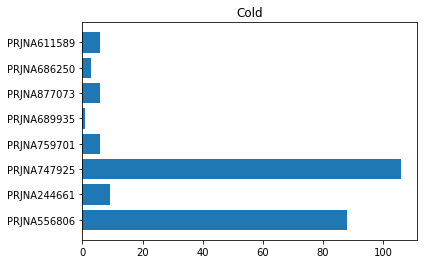

In [13]:
nsamp_bioprojects("Cold",tpm)

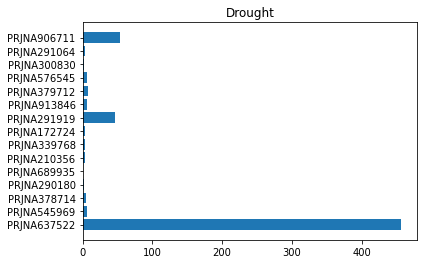

In [14]:
nsamp_bioprojects("Drought",tpm)

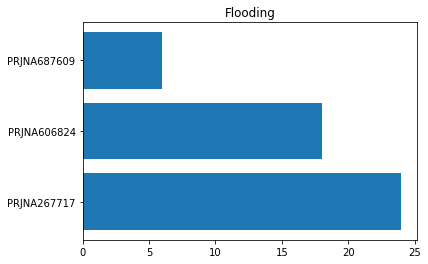

In [15]:
nsamp_bioprojects("Flooding",tpm)

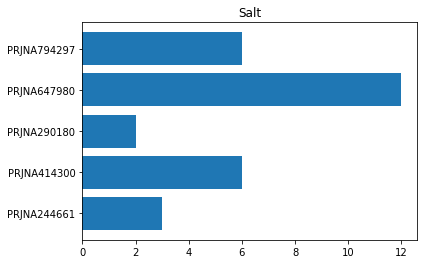

In [16]:
nsamp_bioprojects("Salt",tpm)

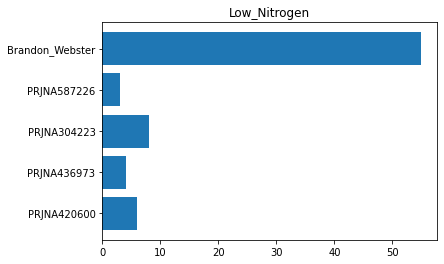

In [17]:
nsamp_bioprojects("Low_Nitrogen",tpm)

In [37]:
# make similar plots for percentage instead of number of samples
def percent_bioprojects(stressor,tpmdf):
    # subset to the specified stressor
    df = tpmdf[tpmdf["Treatment"]==stressor]
    bp = df["BioProject"].unique()
    nsamp = []
    for b in bp:
        d = df[df["BioProject"]==b]
        nsamp.append(len(d["Sample"].unique()))
    # calculate percentages
    pct = [(s/sum(nsamp))*100 for s in nsamp]
    # make plot dataframe
    plotdf = pd.DataFrame(list(zip(bp,nsamp,pct)),columns=["BioProject","N_samples","Percentage"])
    # plot horizontal barplot
    plt.barh(plotdf["BioProject"],plotdf["Percentage"])
    plt.title(stressor)
    return plotdf

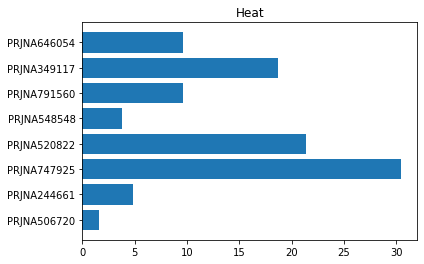

In [20]:
percent_bioprojects("Heat",tpm)

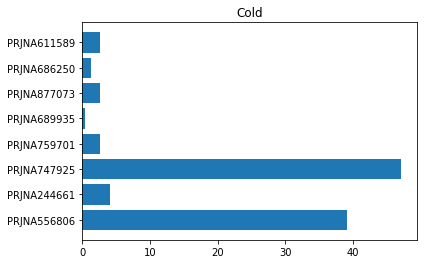

In [21]:
percent_bioprojects("Cold",tpm)

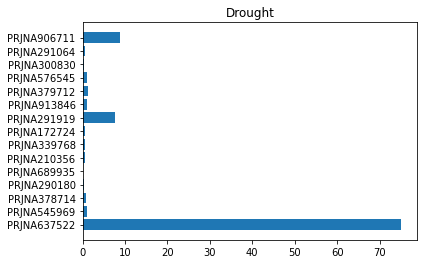

In [22]:
percent_bioprojects("Drought",tpm)

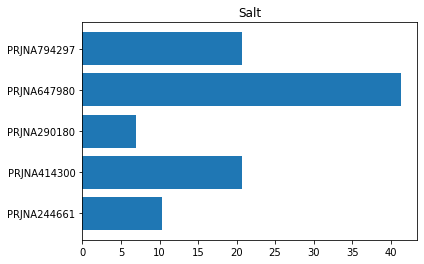

In [23]:
percent_bioprojects("Salt",tpm)

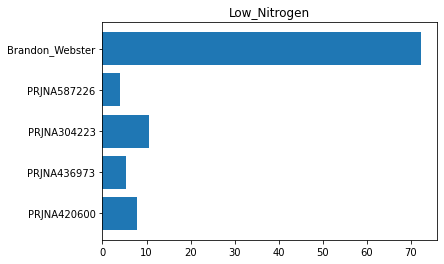

In [40]:
lnbp = percent_bioprojects("Low_Nitrogen",tpm)

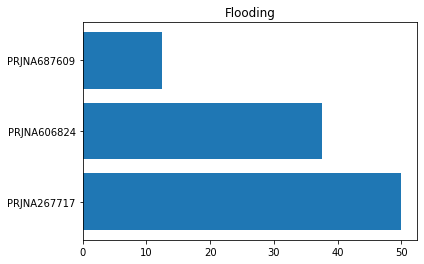

In [38]:
fbp = percent_bioprojects("Flooding",tpm)

In [41]:
lnbp

,BioProject,N_samples,Percentage
0,PRJNA420600,6,7.894737
1,PRJNA436973,4,5.263158
2,PRJNA304223,8,10.526316
3,PRJNA587226,3,3.947368
4,Brandon_Webster,55,72.368421


In [42]:
upperp = 23
lowerp = 17

In [44]:
rbp = random.choice(list(lnbp["BioProject"]))

In [49]:
p = float(lnbp.loc[lnbp["BioProject"]==rbp,"Percentage"])

In [50]:
type(p)

float

In [51]:
p

3.9473684210526314

In [52]:
bplist = []
if upperp>p>lowerp:
    print("correct percentage")
elif p>upperp:
    print("not correct for any usage")
else:
    bplist.append(rbp)

In [53]:
random.sample(list(lnbp["BioProject"]),len(list(lnbp["BioProject"])))

['PRJNA304223', 'PRJNA436973', 'PRJNA420600', 'Brandon_Webster', 'PRJNA587226']

Here are the BioProjects I will use as the test sets for each stressor: (should be approx. 20-35% of samples)

In [26]:
# make dict
bptest = {"Flooding":"PRJNA606824","Low_Nitrogen":"PRJNA420600,PRJNA304223","Salt":"PRJNA414300",
          "Drought":"PRJNA906711,PRJNA291919","Cold":"PRJNA611589,PRJNA877073,PRJNA759701,PRJNA244661",
         "Heat":"PRJNA520822"}

In [27]:
# stressor list
s = ["Drought","Heat","Salt","Cold","Flooding","Low_Nitrogen"]

In [28]:
# make output file of BioProjects
with open("../../data/peripheral_stress_bioprojects_testing.txt","w+") as outfile:
    for i in s:
        outfile.write(bptest[i]+"\n")

In [55]:
l = ["A","B"]
d = ["C","D"]
l+d

['A', 'B', 'C', 'D']

In [109]:
# write a function for the train test split
def split_prep_peripheral(c0_bpstr,dataframe,balance="Up"):
    """
    Args:
        c0_bpstr = string containing BioProject(s) (delimited with commas if more than one) to hold out for testing for class 0
        dataframe = log TPM dataframe with Sample, Label, BioProject, Treatment columns (or Sample as index)
        balance = str: "none", "Up" (downsampling will be done before splitting, outside of this function)
    """
    
    # in case Sample isn't already a column, reset the index and rename the column to Sample
    if "Sample" not in dataframe.columns:
        dataframe = dataframe.reset_index().rename(columns={"index":"Sample"})
    # parse the BioProject string for class 0 test set
    if "," in c0_bpstr:
        c0bp = c0_bpstr.split(",")
    else:
        c0bp = [c0_bpstr]
    # find what percentage of total samples for class 0 these BioProjects contain
    bpsamp = dataframe[dataframe["BioProject"].isin(c0bp)]
    if len(bpsamp["Treatment"].unique())>1:
        bpsamp = bpsamp[bpsamp["Label"]==0]
    nsamp_test = len(bpsamp["Sample"].unique())
    nsamp_all = len(dataframe[dataframe["Label"]==0]["Sample"].unique())
    percent = nsamp_test/nsamp_all
    # how many samples in class 1 comprise this percentage of class 1, +/- 5%?
    class1 = dataframe[dataframe["Label"]==1]
    upperp = percent + 0.02
    lowerp = percent - 0.02
    print(upperp)
    print(lowerp)
    # these are our upper and lower bounds of acceptable sample numbers
    
    # for class 1, set up a dataframe of numbers of samples in each BioProject
    bp = []
    nsamp = []
    pct = []
    for b in list(class1["BioProject"].unique()):
        bp.append(b)
        df = class1[class1["BioProject"]==b]
        nsamp.append(len(df["Sample"].unique()))
        pct.append(len(df["Sample"].unique())/len(class1["Sample"].unique()))
    nsbp = pd.DataFrame(list(zip(bp,nsamp,pct)),columns=["BioProject","N_samples","Percentage"])
    
    # pick BioProjects for the testing set, the sum of whose samples fall within the acceptable bounds
    inlist = random.sample(list(nsbp["BioProject"]),len(list(nsbp["BioProject"])))
    bpfortest = []
    provisionalbp = []
    provisionalpct = []
    toohigh = []
    for b in inlist:
        p = float(nsbp.loc[nsbp["BioProject"]==b,"Percentage"])
        if len(provisionalbp)==0:
            print(len(provisionalbp))
            if upperp>p>lowerp:
                bpfortest.append(b)
                break
            elif p<lowerp:
                provisionalbp.append(b)
                provisionalpct.append(p)
            elif p>upperp:
                toohigh.append(b)
        else:
            print(sum(provisionalpct))
            if upperp>sum(provisionalpct)+p>lowerp:
                provisionalbp.append(b)
                bpfortest = provisionalbp
                break
            elif sum(provisionalpct)+p<lowerp:
                provisionalbp.append(b)
                provisionalpct.append(p)
            elif p>upperp:
                toohigh.append(b)
    #print(bpfortest)
                
    # for the future: find what actual percent of the class 1 data the testing BioProjects comprise
    tc1 = class1[class1["BioProject"].isin(bpfortest)]
    n = len(tc1["Sample"].unique())
    pc1 = (n/len(class1["Sample"].unique()))*100
    # also save the percentage of the class 0 BioProjects
    pc0 = percent*100
    
    # combine an omnibus list of the BioProjects comprising the test set for both classes
    alltestbp = bpfortest+c0bp
    
    # split test from train data
    test = dataframe[dataframe["BioProject"].isin(alltestbp)]
    # pull out training data
    train = dataframe[~dataframe["Sample"].isin(test["Sample"])]
    # for both sets, make Sample the index again
    test = test.set_index("Sample")
    train = train.set_index("Sample")
    # drop BioProject and Treatment columns from both sets
    test = test.drop(["BioProject","Treatment"],axis=1)
    train = train.drop(["BioProject","Treatment"],axis=1)
    # generate X_train, X_test, y_train, and y_test
    ## where X = gene expression values and y = class labels
    train_X = train.drop("Label",axis=1)
    y_train = train["Label"]
    test_X = test.drop("Label",axis=1)
    y_test = test["Label"]
    # if upsampling: do the upsampling using SMOTE
    if balance=="Up":
        sm = SMOTE(random_state=42)
        train_X, y_train = sm.fit_resample(train_X,y_train)
    # for X_train and X_test: scale data to a z-score
    scalar = StandardScaler()
    X_train = scalar.fit_transform(train_X)
    X_test = scalar.fit_transform(test_X)
    # return training and test data as well as percentages (for saving with the hyperparameters later)
    return X_train, y_train, X_test, y_test, pc0, pc1

In [57]:
def pre_split_transform(raw_tpm,balanced,downsample=False):
    """
    Args:
        raw_tpm = dataframe containing raw TPM values, columns for Sample, BioProject, Treatment, Label
        balanced = Boolean variable, True or False (result of check_if_balanced())
        downsample = Boolean variable, True or False, default False (set manually outside function)
    """
    # if data have treatment column, drop it
    #if "Treatment" in raw_tpm.columns:
    #    raw_tpm = raw_tpm.drop("Treatment",axis=1)
    # temporarily, set index to Sample and drop BioProject, Label, & Treatment columns
    blt = raw_tpm[["Sample","BioProject","Treatment","Label"]]
    tpmi = raw_tpm.set_index("Sample").drop(["BioProject","Treatment","Label"],axis=1)
    # remove zero-variance genes
    vttpm = variance_threshold_selector(tpmi)
    # log-transform TPM
    vttpm_log = vttpm.apply(lambda x: np.log2(x+1))
    # downsample data if needed
    if balanced!=True:
        if downsample==True:
            # add back labels
            vttpm_log = blt[["Sample","Label"]].merge(vttpm_log.reset_index().rename(columns={"index":"Sample"}))
            # set Sample as index
            vttpm_log = vttpm_log.set_index("Sample")
            # downsample the data
            vttpm_log = downsample(vttpm_log)
    # add treatment, labels, and BioProject back in, set Sample as the index again
    labeled = blt.merge(vttpm_log.reset_index().rename(columns={"index":"Sample"}))
    labeled.set_index("Sample",inplace=True)
    # drop rows containing NaN values
    labeled = labeled.dropna(axis=0)
    # return dataframe
    return labeled

In [58]:
def variance_threshold_selector(data):
    selector = VarianceThreshold()
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def check_if_balanced(labeled_tpm):
    """
    Args:
        labeled_tpm = raw TPM with columns for Sample, BioProject, Label, Treatment
    """
    if labeled_tpm["Label"].value_counts()[0] == labeled_tpm["Label"].value_counts()[1]:
        return True
    else:
        return False

def downsample(dataframe):
    """
    Args:
        dataframe = a log TPM dataframe with a Label column and Sample set as the index
    """
    # generate a variable of value counts
    vc = dataframe["Label"].value_counts()

    # subset data to only samples labeled 1
    ones_only = dataframe[dataframe["Label"]==1]

    # downsample from the subsetted dataframe
    ds = ones_only.sample(n=vc[1],random_state=42)

    # subset original data to control samples
    zeroes = dataframe[dataframe["Label"]==0]

    # concatenate controls and downsampled stress samples
    downsampled = pd.concat([ds,zeroes])
    # return dataframe
    return downsampled

In [59]:
tpm.head()

,Sample,BioProject,Treatment,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030,Label
0,SRR11933261,PRJNA637522,Drought,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,...,0.000000,0.0,0.000000,0.0,0.309501,0.0,0.000000,0.0,0.000000,1
1,SRR11933272,PRJNA637522,Drought,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,...,0.127878,0.0,0.000000,0.0,6.703281,0.0,0.000000,0.0,0.000000,1
2,SRR11933250,PRJNA637522,Drought,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,...,0.000000,0.0,0.000000,0.0,0.417565,0.0,0.254123,0.0,1.213349,1
4,SRR11933040,PRJNA637522,Drought,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,...,0.012158,0.0,0.000000,0.0,9.625225,0.0,0.000000,0.0,2.352959,1
5,SRR11932822,PRJNA637522,Drought,37.430009,27.508819,0.000000,29.510498,7.005587,0.367545,0.314919,...,0.000000,0.0,0.287114,0.0,0.000000,0.0,0.000000,0.0,1.604105,1


In [60]:
sampling = "Up"
bal = check_if_balanced(tpm)
if sampling == "Down":
    ds = True
    us = "none"
elif sampling == "Up":
    ds = False
    us = "Up"
else:
    ds = False
    us = "none"

In [64]:
import os
import argparse
import numpy as np
import pandas as pd
import random
import json
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

In [65]:
log_tpm = pre_split_transform(tpm,bal,ds)

In [110]:
X_train, y_train, X_test, y_test, pc0, pc1 = split_prep_peripheral(bptest["Heat"],log_tpm,us)

0.233903743315508
0.19390374331550803
0
0.006085192697768763
0.012170385395537525
0.018255578093306288
0.02231237322515213
0.02231237322515213
0.12981744421906694
0.15415821501014199
0.15720081135902636
0.16937119675456389
0.17748478701825557
0.18356997971602435
0.18559837728194728
0.18559837728194728
0.19168356997971603


In [111]:
pc0

21.390374331550802

In [112]:
pc1

20.99391480730223

In [84]:
provisionalbp = ['PRJNA291919', 'PRJNA689935', 'PRJNA210356', 'PRJNA877073', 'PRJNA290180', 'PRJNA414300', 'PRJNA759701', 'PRJNA686250', 'PRJNA747925', 'PRJNA913846', 'PRJNA606824', 'PRJNA291064', 'PRJNA339768', 'PRJNA379712', 'PRJNA267717', 'PRJNA576545', 'PRJNA172724', 'PRJNA794297', 'PRJNA611589', 'PRJNA587226', 'PRJNA300830', 'PRJNA420600', 'Brandon_Webster', 'PRJNA436973', 'PRJNA378714', 'PRJNA244661', 'PRJNA906711', 'PRJNA687609', 'PRJNA647980', 'PRJNA545969', 'PRJNA304223']

In [91]:
ptpm = log_tpm[log_tpm["BioProject"].isin(provisionalbp)]
ptpm = ptpm[ptpm["Treatment"]!="Heat"]

In [92]:
len(ptpm.index)

441

In [89]:
c1 = log_tpm[log_tpm["Label"]==1]

In [93]:
len(ptpm.index)/len(c1.index)

0.44726166328600403